# The Price is Right

Today we build a more complex solution for estimating prices of goods.

1. Day 2.0 notebook: create a RAG database with our 400,000 training data
2. Day 2.1 notebook: visualize in 2D
3. Day 2.2 notebook: visualize in 3D
4. Day 2.3 notebook: build and test a RAG pipeline with GPT-4o-mini
5. Day 2.4 notebook: (a) bring back our Random Forest pricer (b) Create a Ensemble pricer that allows contributions from all the pricers

Phew! That's a lot to get through in one day!

## PLEASE NOTE:

We already have a very powerful product estimator with our proprietary, fine-tuned LLM. Most people would be very satisfied with that! The main reason we're adding these extra steps is to deepen your expertise with RAG and with Agentic workflows.

## We will go fast today! Hold on to your hat..

In [1]:
# imports

import os
import re
import math
import json
from tqdm import tqdm
import random
from dotenv import load_dotenv
from huggingface_hub import login
import matplotlib.pyplot as plt
import numpy as np
import pickle
from openai import OpenAI
from sentence_transformers import SentenceTransformer
from datasets import load_dataset
import chromadb
from items import Item
from testing import Tester

In [2]:
# environment

load_dotenv(override=True)
os.environ['OPENAI_API_KEY'] = os.getenv('OPENAI_API_KEY', 'your-key-if-not-using-env')
os.environ['HF_TOKEN'] = os.getenv('HF_TOKEN', 'your-key-if-not-using-env')

In [3]:
openai = OpenAI()

In [4]:
# Load in the test pickle file
# See the section "Back to the PKL files" in the day2.0 notebook
# for instructions on obtaining this test.pkl file

with open('test.pkl', 'rb') as file:
    test = pickle.load(file)

In [5]:
def make_context(similars, prices):
    message = "To provide some context, here are some other items that might be similar to the item you need to estimate.\n\n"
    for similar, price in zip(similars, prices):
        message += f"Potentially related product:\n{similar}\nPrice is ${price:.2f}\n\n"
    return message

In [6]:
def messages_for(item, similars, prices):
    system_message = "You estimate prices of items. Reply only with the price, no explanation"
    user_prompt = make_context(similars, prices)
    user_prompt += "And now the question for you:\n\n"
    user_prompt += item.test_prompt().replace(" to the nearest dollar","").replace("\n\nPrice is $","")
    return [
        {"role": "system", "content": system_message},
        {"role": "user", "content": user_prompt},
        {"role": "assistant", "content": "Price is $"}
    ]

In [7]:
DB = "products_vectorstore"

In [8]:
client = chromadb.PersistentClient(path=DB)
collection = client.get_or_create_collection('products')

In [9]:
def description(item):
    text = item.prompt.replace("How much does this cost to the nearest dollar?\n\n", "")
    return text.split("\n\nPrice is $")[0]

In [10]:
description(test[0])

'TLAPS Compatible With Toyota Tacoma Non-Factory LED LED DRL Black Housing Full LED Sequential Quad Projector Headlights With Amber Reflector\nApplication Compatible With Toyota Tacoma Models With Non-Factory LED DRL ( Daytime Running Lights ) Headlights Only ( Attention Note Will Not Fit Models With Factory LED DRL ( Daytime Running Lights ) Headlights, Hyper Blinking May Occur If Used With Other Branded Aftermarket LED Lighting ) Full LED Sequential Projector Headlights ( Attention These LED Projector Headlights Will ONLY Replace Factory OEM Halogen Style Headlights, Not Compatible With Factory Upgraded Projectors Or LED Headlights, Hyper Blinking May Occur If Used With Other Branded Aftermarket LED Lighting. For More Information Please Contact Us ) Quad-LED Projector Design With Amber Sequential'

In [11]:
model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')

In [12]:
def vector(item):
    return model.encode([description(item)])

In [13]:
def find_similars(item):
    results = collection.query(query_embeddings=vector(item).astype(float).tolist(), n_results=5)
    documents = results['documents'][0][:]
    prices = [m['price'] for m in results['metadatas'][0][:]]
    return documents, prices

In [14]:
print(test[1].prompt)

How much does this cost to the nearest dollar?

Witonics Capacitor Replacement Kit for LG
This capacitor replacement kit is used to repair the power and inverter board of your TV. The capacitors in this kit are of high quality to replace the failed ones on your board. Problems/symptoms of the failed capacitors pink dot/startup problems, slow startup, or after starting up, the picture starts to disappear, flickering of the TV screen, clicking noise or pound/power LED is on, however, no sound. 7 high-temperature capacitors, not including the large capacitors 7 inches solder wire (lead-free), 4 inches of solder wick General instructions are included Manufacturer Witonics, Brand Witonics, Is Discontinued No, Manufacturer Part Rank Automotive Soldering Parts & Accessories 5106,

Price is $12.00


In [15]:
documents, prices = find_similars(test[1])

In [16]:
print(make_context(documents, prices))

To provide some context, here are some other items that might be similar to the item you need to estimate.

Potentially related product:
Witonics Capacitor Replacement Kit for Sharp
This capacitor replacement kit is used to repair the power and inverter board of your TV. The capacitors in this kit are of high quality to replace the failed ones on your board. Problems/symptoms of the failed capacitors pink dot/startup problems, slow startup, or after starting up, the picture starts to disappear, flickering of the TV screen, clicking noise or pound/power LED is on, however, no sound. 11 high-temperature capacitors, not including the large capacitors 7 inches solder wire (lead-free), 4 inches of solder wick General instructions are included Manufacturer Witonics, Part Is Discontinued No, Shape Rectangular, Quantity 1, Rank Industrial & Scientific Soldering Parts & Accessories
Price is $11.95

Potentially related product:
Witonics Capacitor Replacement Kit for Samsung LCD/Plasma TV with De

In [18]:
from pprint import pprint
pprint(messages_for(test[1], documents, prices))

[{'content': 'You estimate prices of items. Reply only with the price, no '
             'explanation',
  'role': 'system'},
 {'content': 'To provide some context, here are some other items that might be '
             'similar to the item you need to estimate.\n'
             '\n'
             'Potentially related product:\n'
             'Witonics Capacitor Replacement Kit for Sharp\n'
             'This capacitor replacement kit is used to repair the power and '
             'inverter board of your TV. The capacitors in this kit are of '
             'high quality to replace the failed ones on your board. '
             'Problems/symptoms of the failed capacitors pink dot/startup '
             'problems, slow startup, or after starting up, the picture starts '
             'to disappear, flickering of the TV screen, clicking noise or '
             'pound/power LED is on, however, no sound. 11 high-temperature '
             'capacitors, not including the large capacitors 7 inches 

In [19]:
def get_price(s):
    s = s.replace('$','').replace(',','')
    match = re.search(r"[-+]?\d*\.\d+|\d+", s)
    return float(match.group()) if match else 0

In [20]:
get_price("The price for this is $99.99")

99.99

In [21]:
# The function for gpt-4o-mini

def gpt_4o_mini_rag(item):
    documents, prices = find_similars(item)
    response = openai.chat.completions.create(
        model="gpt-4o-mini", 
        messages=messages_for(item, documents, prices),
        seed=42,
        max_tokens=5
    )
    reply = response.choices[0].message.content
    return get_price(reply)

In [22]:
gpt_4o_mini_rag(test[1])

11.95

In [23]:
test[1].price

11.95

1: Guess: $399.00 Truth: $389.00 Error: $10.00 SLE: 0.00 Item: TLAPS 7422444293245 Compatible With 2016...
2: Guess: $11.95 Truth: $11.95 Error: $0.00 SLE: 0.00 Item: Witonics Capacitor Replacement Kit for L...
3: Guess: $39.99 Truth: $57.99 Error: $18.00 SLE: 0.13 Item: EPSIRMP E5T62172 Mass Air Flow Meter Sen...
4: Guess: $28.99 Truth: $32.99 Error: $4.00 SLE: 0.02 Item: 2 Pc 4 in 1 Double Box Ratcheting Wrench...
5: Guess: $155.49 Truth: $136.94 Error: $18.55 SLE: 0.02 Item: Can-Am 2013-2018 Outlander 650 Outlander...
6: Guess: $119.00 Truth: $116.10 Error: $2.90 SLE: 0.00 Item: OREI KVM 4K HDMI Over Ethernet Extender ...
7: Guess: $183.92 Truth: $249.97 Error: $66.05 SLE: 0.09 Item: MAXLINER Custom Fit Floor Mats and Cargo...
8: Guess: $114.95 Truth: $151.89 Error: $36.94 SLE: 0.08 Item: Alpinestars (474512-20-XS/S White X-Smal...
9: Guess: $118.02 Truth: $110.99 Error: $7.03 SLE: 0.00 Item: SCITOO automotive replacement engine rad...
10: Guess: $389.99 Truth: $218.78 Error: $171.2

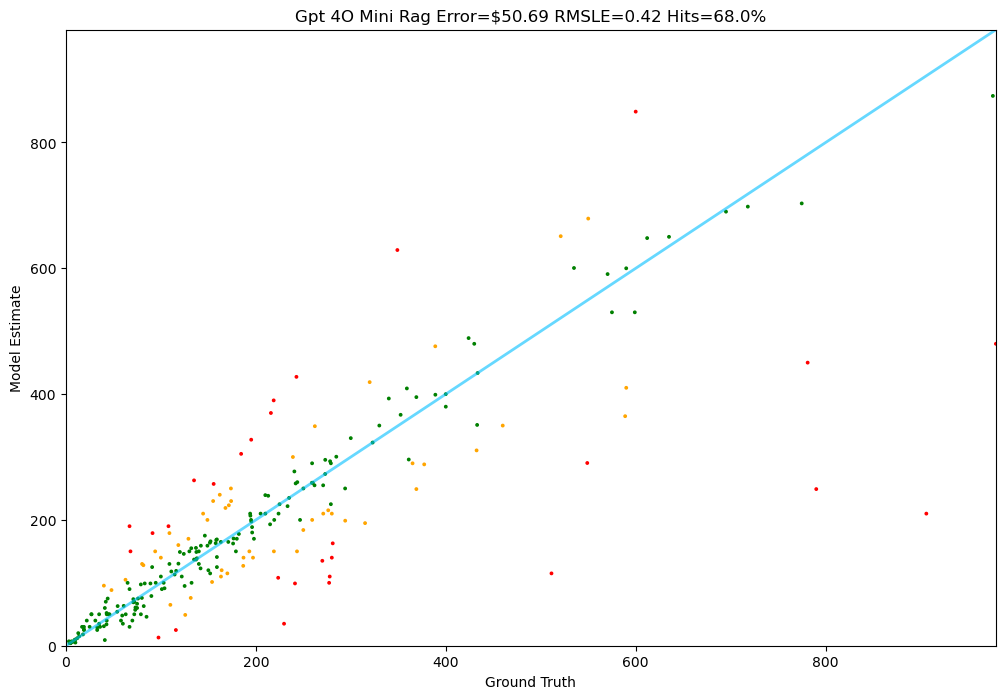

In [24]:
Tester.test(gpt_4o_mini_rag, test)

## Optional Extra: Trying a DeepSeek API call instead of OpenAI

If you have a DeepSeek API key, we will use it here as an alternative implementation; otherwise skip to the next section..

In [ ]:
# Connect to DeepSeek using the OpenAI client python library

deepseek_api_key = os.getenv("DEEPSEEK_API_KEY")
deepseek_via_openai_client = OpenAI(api_key=deepseek_api_key,base_url="https://api.deepseek.com")

In [ ]:
# Added some retry logic here because DeepSeek is very oversubscribed and sometimes fails..

def deepseek_api_rag(item):
    documents, prices = find_similars(item)
    retries = 8
    done = False
    while not done and retries > 0:
        try:
            response = deepseek_via_openai_client.chat.completions.create(
                model="deepseek-chat", 
                messages=messages_for(item, documents, prices),
                seed=42,
                max_tokens=8
            )
            reply = response.choices[0].message.content
            done = True
        except Exception as e:
            print(f"Error: {e}")
            retries -= 1
    return get_price(reply)

In [ ]:
deepseek_api_rag(test[1])

In [ ]:
Tester.test(deepseek_api_rag, test)

## And now to wrap this in an "Agent" class

In [25]:
from agents.frontier_agent import FrontierAgent

In [26]:
# Let's print the logs so we can see what's going on

import logging
root = logging.getLogger()
root.setLevel(logging.INFO)

In [27]:
agent = FrontierAgent(collection)

INFO:root:[Frontier Agent] Initializing Frontier Agent
INFO:root:[Frontier Agent] Frontier Agent is setting up with OpenAI
INFO:sentence_transformers.SentenceTransformer:Use pytorch device_name: cuda
INFO:sentence_transformers.SentenceTransformer:Load pretrained SentenceTransformer: sentence-transformers/all-MiniLM-L6-v2
INFO:root:[Frontier Agent] Frontier Agent is ready


In [28]:
agent.price("Quadcast HyperX condenser mic for high quality podcasting")

INFO:root:[Frontier Agent] Frontier Agent is performing a RAG search of the Chroma datastore to find 5 similar products


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:root:[Frontier Agent] Frontier Agent has found similar products
INFO:root:[Frontier Agent] Frontier Agent is about to call gpt-4o-mini with context including 5 similar products
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:root:[Frontier Agent] Frontier Agent completed - predicting $154.59


154.59

In [29]:
from agents.specialist_agent import SpecialistAgent

In [30]:
agent2 = SpecialistAgent()

INFO:root:[Specialist Agent] Specialist Agent is initializing - connecting to modal
C:\Users\cosar\anaconda3\envs\llms\Lib\asyncio\events.py:84: DeprecationError: 2025-01-27: `modal.Cls.lookup` is deprecated and will be removed in a future release. It can be replaced with `modal.Cls.from_name`.

See https://modal.com/docs/guide/modal-1-0-migration for more information.
  self._context.run(self._callback, *self._args)
INFO:root:[Specialist Agent] Specialist Agent is ready


In [ ]:
agent2.price("Quadcast HyperX condenser mic for high quality podcasting")